#### 2CNN + 2LSTM Layers 
#### Stop word removal, Lemmatization
#### Google Word2Vec, 300 vectors per word

In [ ]:
#import necessary parameters
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ProjectFakeNews/processed_fake_news.csv') # import the preprocessed dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   72134 non-null  int64 
 1   text         72095 non-null  object
 2   label        72134 non-null  int64 
 3   lemm_sent    72134 non-null  object
 4   rephrased    72134 non-null  object
 5   joined_lemm  71350 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.3+ MB


In [ ]:
df.head()

,Unnamed: 0,text,label,lemm_sent,rephrased,joined_lemm
0,0,No comment is expected from Barack Obama Membe...,1,"['comment', 'expect', 'barack', 'obama', 'memb...","['comment', 'expect', 'barack_obama', 'member'...",comment expect barack_obama member fyf911 fuky...
1,1,Did they post their votes for Hillary already?,1,"['post', 'vote', 'hillary']","['post', 'vote_hillary']",post vote_hillary
2,2,"Now, most of the demonstrators gathered last ...",1,"['demonstrator', 'gather', 'night', 'exercise'...","['demonstrator_gather', 'night', 'exercise_con...",demonstrator_gather night exercise_constitutio...
3,3,A dozen politically active pastors came here f...,0,"['dozen', 'politically', 'active', 'pastor', '...","['dozen', 'politically_active', 'pastor', 'com...",dozen politically_active pastor come private_d...
4,4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"['rs-28', 'sarmat', 'missile', 'dub', 'satan',...","['rs-28_sarmat', 'missile_dub', 'satan_2', 're...",rs-28_sarmat missile_dub satan_2 replace_ss-18...


In [ ]:
df['lemm_sent'] = df.lemm_sent.apply(lambda x: eval(x))
# convert the lemm_sent colum back to list, as it is saved as a string.

In [ ]:
df['lemm_sent'] = df['lemm_sent'].apply(lambda x: ' '.join([str((i)) for i in x]))
# join the tokens to make a sentence

In [ ]:
# drop unnecessary columns
df.drop(labels=['text','rephrased','joined_lemm'], axis='columns', inplace=True)

In [ ]:
df.head()

,Unnamed: 0,label,lemm_sent
0,0,1,comment expect barack obama member fyf911 fuky...
1,1,1,post vote hillary
2,2,1,demonstrator gather night exercise constitutio...
3,3,0,dozen politically active pastor come private d...
4,4,1,rs-28 sarmat missile dub satan 2 replace ss-18...


In [ ]:
df.isna().sum() # check for any null values in the dataset

Unnamed: 0    0
label         0
lemm_sent     0
dtype: int64

In [ ]:
#invoke garbage collector to free ram
import gc
gc.collect()

0

In [ ]:
from gensim.models.keyedvectors import KeyedVectors

In [ ]:
# load the google word2vec model to word_vectors
word_vectors = KeyedVectors.load_word2vec_format(r'/content/drive/MyDrive/ProjectFakeNews/GoogleNews-vectors-negative300.bin',binary=True)

In [ ]:
# checking similar words to a word
word_vectors.most_similar('computer')

[('computers', 0.7979379892349243),
 ('laptop', 0.6640493273735046),
 ('laptop_computer', 0.6548868417739868),
 ('Computer', 0.647333562374115),
 ('com_puter', 0.6082080006599426),
 ('technician_Leonard_Luchko', 0.5662748217582703),
 ('mainframes_minicomputers', 0.5617720484733582),
 ('laptop_computers', 0.5585449934005737),
 ('PC', 0.5539618730545044),
 ('maker_Dell_DELL.O', 0.5519254207611084)]

In [ ]:
texts = df['lemm_sent']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 72134 texts.


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [ ]:
# setting our embedding parameters
# MAX_NUM_WORDS = 1000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.2

In [ ]:
# tokenizing sentences into words
#num_words=MAX_NUM_WORDS
tokenizer = Tokenizer()
# using fit_on_texts method assigning values to particular words
tokenizer.fit_on_texts(texts)
# texts_to_sequences method is used to give particular integer values to word
sequences = tokenizer.texts_to_sequences(texts)

# calculating word_index
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 233928 unique tokens.


In [ ]:
texts[1]

'post vote hillary'

In [ ]:
sequences[1][:10]

[103, 40, 38]

In [ ]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 17:
        break

say -> 1
s -> 2
trump -> 3
president -> 4
people -> 5
year -> 6
state -> 7
clinton -> 8
mr -> 9
u -> 10
new -> 11
time -> 12
like -> 13
government -> 14
go -> 15
tell -> 16
obama -> 17


In [ ]:
vocab_size = len(tokenizer.word_index) + 1 # vocabulary size

In [ ]:
vocab_size

233929

In [ ]:
#based on the above description deciding we can keep max length as 500, as 3rd quartile is 217
MAX_SEQUENCE_LENGTH = 1000

In [ ]:
# padding data to the same length for each samples
data = pad_sequences(sequences,
                     maxlen=MAX_SEQUENCE_LENGTH,
                     padding='post',
                     truncating='post')
print(len(word_index))
print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

233928
Found 233928 unique tokens.
Shape of data tensor: (72134, 1000)
Shape of label tensor: (72134,)


In [ ]:
# create an embedding matrix from the word2vec model to pass to the embedding layer as weights
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM) # if word is not found random numbers are assigned.

del word_vectors

In [ ]:
embedding_matrix.shape

(233929, 300)

In [ ]:
from sklearn.model_selection import train_test_split


# test train and validation split
x, x_test, y, y_test = train_test_split(data,
                                        labels,
                                        test_size=0.2)

x_train, x_val, y_train, y_val = train_test_split(x,
                                                  y,
                                                  test_size=0.1)

print('train size:',x_train.shape[0])
print('test size:', x_test.shape[0])
print('val Size:', x_val.shape[0])

train size: 51936
test size: 14427
val Size: 5771


In [ ]:
from keras import layers
from keras.models import Sequential

In [ ]:
dropout = 0.4
model = Sequential()

# defining embedding layer where embedding dimension/ vector size is defined as 300 and input length is set as 1000.
model.add(layers.Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# defining a convolution layer, number of filters are set as 128 and kernal size is defined as 1 X 5.
model.add(layers.Conv1D(128,5, activation='ReLU'))
# max pooling layer
model.add(layers.MaxPool1D(2))
# add dropout
model.add(layers.Dropout(dropout))
# defining a convolution layer, number of filters are set as 64 and kernal size is defined as 1 X 3.
model.add(layers.Conv1D(64,3, activation='ReLU'))
model.add(layers.MaxPooling1D(2, strides= 2))
# define a LSTM layer with 64 units
model.add(layers.LSTM(64,return_sequences=True))
# define a LSTM layer with 32 units
model.add(layers.LSTM(32,return_sequences=True))
# flatten
model.add(layers.Flatten())
# add dense layer with 64 neurons and ReLu activation function
model.add(layers.Dense(64, activation='ReLU'))
model.add(layers.Dropout(dropout))
# add dense layer with 16 neurons and ReLu activation function
model.add(layers.Dense(16, activation='ReLU'))
# output layer with 1 neuron and sigmoid activation for binary classification
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

del embedding_matrix

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         70178700  
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 498, 128)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 498, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 496, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 248, 64)          0         
 1D)                                                    

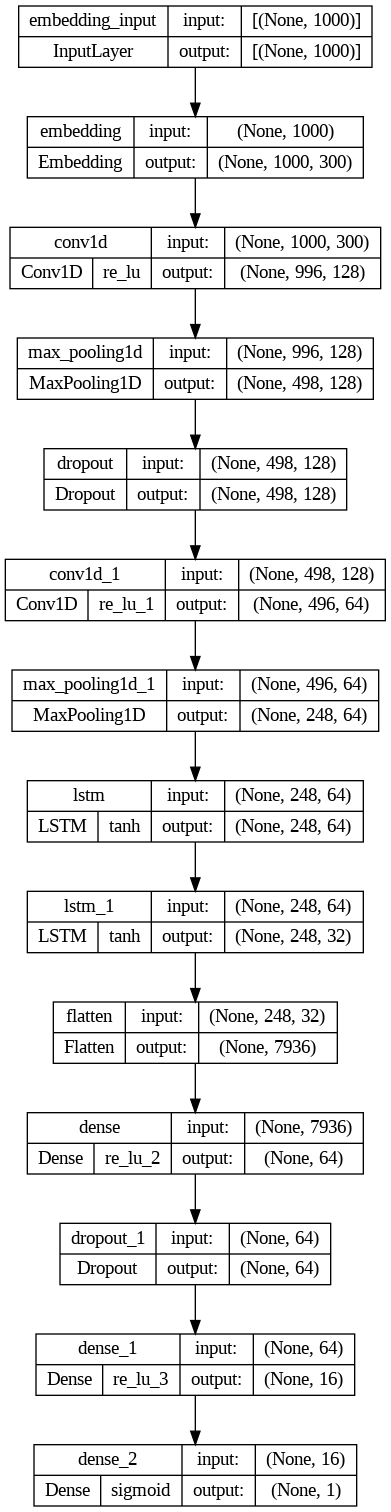

In [ ]:
# visalizing the layers of model.
import tensorflow as tf

tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)

In [ ]:
# train the model
import time as t
start = t.time()
history = model.fit(x_train,
                    y_train,
                    batch_size=128,initial_epoch=0,
                    epochs=15,validation_data=(x_val, y_val))

print("total training time:",t.time()-start)

Epoch 1/15
406/406 [==============================] - 46s 76ms/step - loss: 0.2313 - accuracy: 0.9002 - val_loss: 0.1081 - val_accuracy: 0.9601
Epoch 2/15
406/406 [==============================] - 29s 72ms/step - loss: 0.0892 - accuracy: 0.9668 - val_loss: 0.0841 - val_accuracy: 0.9683
Epoch 3/15
406/406 [==============================] - 30s 73ms/step - loss: 0.0647 - accuracy: 0.9767 - val_loss: 0.0779 - val_accuracy: 0.9745
Epoch 4/15
406/406 [==============================] - 30s 74ms/step - loss: 0.0438 - accuracy: 0.9848 - val_loss: 0.0712 - val_accuracy: 0.9754
Epoch 5/15
406/406 [==============================] - 30s 75ms/step - loss: 0.0344 - accuracy: 0.9876 - val_loss: 0.0786 - val_accuracy: 0.9773
Epoch 6/15
406/406 [==============================] - 30s 75ms/step - loss: 0.0272 - accuracy: 0.9901 - val_loss: 0.0747 - val_accuracy: 0.9778
Epoch 7/15
406/406 [==============================] - 30s 74ms/step - loss: 0.0260 - accuracy: 0.9907 - val_loss: 0.0634 - val_accuracy:

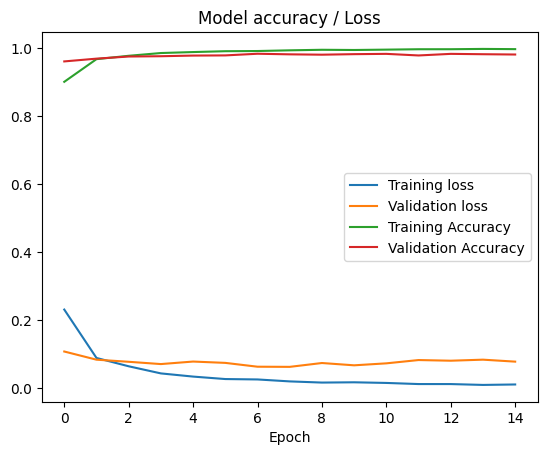

In [ ]:
# plot training and validation accuracy / loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy / Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss','Training Accuracy','Validation Accuracy'])
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,classification_report,roc_curve

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing accuraries are reported
    '''
    # training acc
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)

    # testing acc
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)


    # accuracy = accuracy_score(y_test,y_pred_tex)
    roc_auc =roc_auc_score(y_test, y_predict_test)
    precision = precision_score(y_pred=y_predict_test, y_true=y_test,zero_division=1)
    recall = recall_score(y_pred=y_predict_test, y_true=y_test,zero_division=1)

    cr = classification_report(y_test, y_predict_test,zero_division=1)


    fpr, tpr, threshold = roc_curve(y_test, y_predict_test)
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label= 'Model')
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.title('ROC Curve',fontsize=20)
    plt.legend(fontsize=12)
    plt.show()

    roc_auc_sc = roc_auc_score(y_test,y_predict_test)

    return train_acc, test_acc,cr,roc_auc_sc

451/451 [==============================] - 6s 12ms/step


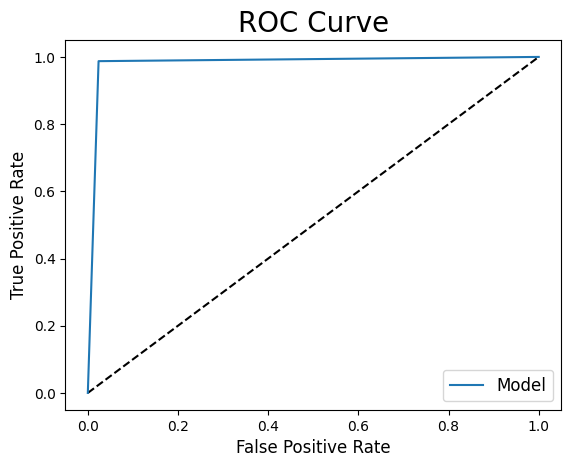

Training Accuracy: 99.97%
Testing Accuracy: 98.19%
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      7048
           1       0.98      0.99      0.98      7379

    accuracy                           0.98     14427
   macro avg       0.98      0.98      0.98     14427
weighted avg       0.98      0.98      0.98     14427

AUC score 0.9817800584196124
Total time required for testing 28.443965196609497


In [ ]:
import time as t
start = t.time()
train_acc, test_acc,cr,roc_auc_sc = evaluate_model(lambda x: np.rint(model.predict(x)),
                                     x_train,
                                     y_train,
                                     x_test,
                                     y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))
print("Classification Report:\n",cr)
print("AUC score",roc_auc_sc)
print("Total time required for testing",t.time()-start)

In [ ]:
results = model.evaluate(x_test,y_test)
print('test loss, test acc:', results)

451/451 [==============================] - 6s 12ms/step - loss: 0.0797 - accuracy: 0.9819
test loss, test acc: [0.07967934012413025, 0.981908917427063]


In [ ]:
# model.save('google_word2vec')